# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [ ]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [ ]:
# Add any additional import statements you need here

from nltk.tokenize import word_tokenize
import zipfile


In [81]:
import os

zip_path = "M1 Assignment Data.zip"
extract_to = "folder"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [82]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/folder/M1 Results/"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_path = os.path.join(data_location, "twitter")
lyrics_path = os.path.join(data_location, "lyrics")

positive_words_file = "/content/positive-words.txt"
negative_words_file = "/content/negative-words.txt"
tidy_text_file = "/content/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




In [83]:
# Read in the lyrics data
lyrics_data = {}

for artist in os.listdir(lyrics_path):
    artist_path = os.path.join(lyrics_path, artist)
    if os.path.isdir(artist_path):
        lyrics_data[artist] = {}
        for song_file in os.listdir(artist_path):
            if song_file.endswith(".txt"):
                with open(os.path.join(artist_path, song_file), 'r', encoding='utf-8') as f:
                    content = f.read()
                    song_title = song_file.replace(".txt", "")
                    lyrics_data[artist][song_title] = content

In [84]:
# Read in the twitter data
twitter_data = {}

for file in os.listdir(twitter_path):
    if file.endswith("_followers_data.txt"):
        artist = file.split("_")[0]
        path = os.path.join(twitter_path, file)

        # Read TSV, skipping any bad rows
        df = pd.read_csv(path, sep="\t", encoding='utf-8', on_bad_lines='skip')

        # Extract non-empty descriptions
        descriptions = df['description'].dropna()
        descriptions = [desc for desc in descriptions if isinstance(desc, str) and desc.strip() != ""]

        twitter_data[artist] = descriptions

In [87]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.
word_dict = {}

with open(positive_words_file, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.strip()
        if word and not word.startswith(";"):
            word_dict[word] = 1

with open(negative_words_file, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.strip()
        if word and not word.startswith(";"):
            word_dict[word] = -1

tidy_df = pd.read_csv(tidy_text_file, sep="\t", header=0)
for _, row in tidy_df.iterrows():
    word = row["word"]
    sentiment = row["sentiment"]
    word_dict[word] = 1 if sentiment == "positive" else -1

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [90]:
def bing_liu_score(text):
    sentiment_score = 0
    words = word_tokenize(text.lower())
    for word in words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score

song_sentiment_scores = []

for artist, songs in lyrics_data.items():
    for song, text in songs.items():
        score = bing_liu_score(text)
        song_sentiment_scores.append({
            "artist": artist,
            "song": song,
            "sentiment_score": score
        })

# Create DataFrame
sentiment_df = pd.DataFrame(song_sentiment_scores)
sentiment_df.head()

,artist,song,sentiment_score
0,robyn,robyn_healthylove,26
1,robyn,robyn_humanbeing,2
2,robyn,robyn_fembot114519,11
3,robyn,robyn_konichiwabitches,7
4,robyn,robyn_gottoworkitout,17


In [91]:
artist_names = sentiment_df['artist'].unique().tolist()
artist_1, artist_2 = artist_names[0], artist_names[1]

avg_sentiments = sentiment_df.groupby('artist')['sentiment_score'].mean()
print(avg_sentiments)

artist
cher     6.772152
robyn    9.105769
Name: sentiment_score, dtype: float64


In [99]:
# Filter
artist1_df = sentiment_df[sentiment_df['artist'] == artist_1]

# Top and bottom 3 songs
top3_artist1 = artist1_df.sort_values('sentiment_score', ascending=False).head(4)
bottom3_artist1 = artist1_df.sort_values('sentiment_score').head(4)

# Print lyrics
print(f"\nTop 3 songs for {artist_1}:")
for _, row in top3_artist1.iterrows():
    print(f"\n--- {row['song']} ---")
    print(lyrics_data[artist_1][row['song']])

print(f"\nBottom 3 songs for {artist_1}:")
for _, row in bottom3_artist1.iterrows():
    print(f"\n--- {row['song']} ---")
    print(lyrics_data[artist_1][row['song']])


Top 3 songs for robyn:

--- robyn_loveisfree ---
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, ba

In [93]:
# Filter
artist2_df = sentiment_df[sentiment_df['artist'] == artist_2]

# Top and bottom 3 songs
top3_artist2 = artist2_df.sort_values('sentiment_score', ascending=False).head(3)
bottom3_artist2 = artist2_df.sort_values('sentiment_score').head(3)

# Print lyrics
print(f"\nTop 3 songs for {artist_2}:")
for _, row in top3_artist2.iterrows():
    print(f"\n--- {row['song']} ---")
    print(lyrics_data[artist_2][row['song']])

print(f"\nBottom 3 songs for {artist_2}:")
for _, row in bottom3_artist2.iterrows():
    print(f"\n--- {row['song']} ---")
    print(lyrics_data[artist_2][row['song']])


Top 3 songs for cher:

--- cher_loveandunderstanding ---
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times


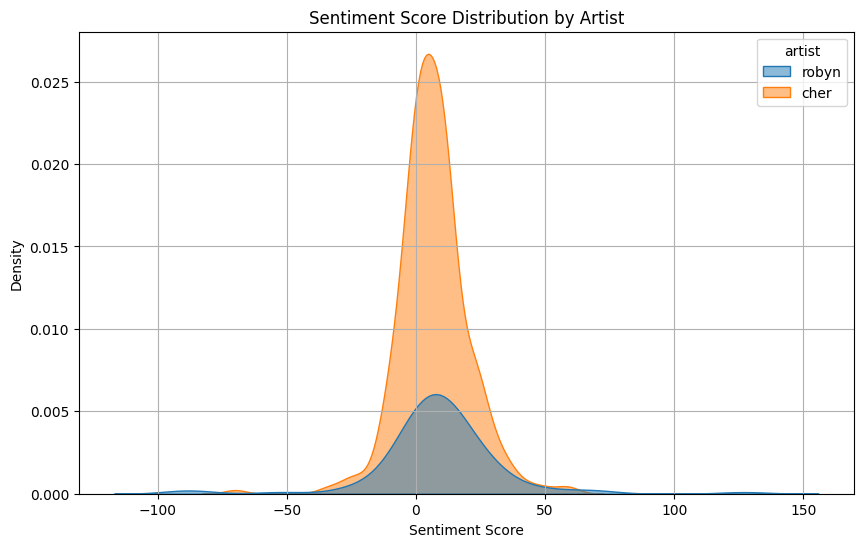

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=sentiment_df, x='sentiment_score', hue='artist', fill=True, alpha=0.5)
plt.title("Sentiment Score Distribution by Artist")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: robyn

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: For Robyn, the three songs with the highest sentiment scores are "Love Is Free," "We Dance to the Beat," and "Between the Lines." The three songs with the lowest scores are "Don't Fucking Tell Me What to Do," "Criminal Intent," and "Love Kills." The higher scores are influenced by the presence of more positive words in the lyrics, such as "love," "dance," and "proud" while the lower-scoring songs contain more negative or aggressive language, which is evident even in their titles.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: For Cher, the three songs with the highest sentiment scores are "Love and Understanding," "I Found You Love," and "Perfection." The three with the lowest scores are "Bang Bang," "Bang Bang (My Baby Shot Me Down)," and "Outrageous." The high sentiment scores are driven by lyrics that focus on uplifting themes and positive emotions, while the lower-scoring songs contain more negative language, which brings down their sentiment.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [95]:
positive_emojis = ['😂', '😊', '😍', '😁', '❤️', '😎', '🤗', '👍', '🎉', '🥳']
negative_emojis = ['😢', '😡', '😠', '💔', '😞', '😩', '😭', '👎', '🤬', '😤']

emoji_sentiment = {}
for emoji_ in positive_emojis:
    emoji_sentiment[emoji_] = 1
for emoji_ in negative_emojis:
    emoji_sentiment[emoji_] = -1

artist_emoji_scores = {}

for artist, descriptions in twitter_data.items():
    total_score = 0
    for desc in descriptions:
        for char in desc:
            if char in emoji_sentiment:
                total_score += emoji_sentiment[char]
    average_score = total_score / len(descriptions) if descriptions else 0
    artist_emoji_scores[artist] = average_score

for artist, avg_score in artist_emoji_scores.items():
    print(f"{artist} average emoji sentiment score: {avg_score:.3f}")

robynkonichiwa average emoji sentiment score: 0.006
cher average emoji sentiment score: 0.013


In [96]:
artist_emoji_counts = {}

for artist, descriptions in twitter_data.items():
    emoji_counter = Counter()
    for desc in descriptions:
        for char in desc:
            if char in emoji_sentiment:
                emoji_counter[char] += 1
    artist_emoji_counts[artist] = emoji_counter

for artist, counter in artist_emoji_counts.items():
    most_common_positive = max((e for e in positive_emojis if e in counter), key=lambda x: counter[x], default=None)
    most_common_negative = max((e for e in negative_emojis if e in counter), key=lambda x: counter[x], default=None)

    print(f"{artist}:")
    print(f"  Most popular positive emoji: {most_common_positive} ({counter[most_common_positive]} times)")
    print(f"  Most popular negative emoji: {most_common_negative} ({counter[most_common_negative]} times)\n")

robynkonichiwa:
  Most popular positive emoji: 😎 (280 times)
  Most popular negative emoji: 💔 (60 times)

cher:
  Most popular positive emoji: 😍 (8197 times)
  Most popular negative emoji: 💔 (1616 times)



Q: What is the average sentiment of your two artists?

A: robynkonichiwa has an average sentiment of 0.006 while cher has an average sentiment score of 0.013.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: For robynkonichiwa, the most popular positive emoji is the 😎 (sunglasses) emoji, while the most common negative emoji is 💔 (broken heart). For Cher, the most frequently used positive emoji is 😍 (heart eyes), and the most common negative emoji is also 💔 (broken heart).
